<h1>Import bibliotek</h1>

In [194]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_score, accuracy_score, roc_auc_score, recall_score
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, auc
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree

<h1>Obserwacje na podstawie pierwszego zadania</h1>

Największe szanse na przeżycie miały (w kolejności od największego wpływu cechy):
* kobiety - przeżyło ich ok. 74% kiedy w przypadku mężczyzn było to tylko ok. 19%
* osoby znajdujące się w klasie 1 - tych przeżyło ok 63%, dla porównania osób z klasy 3 przeżyło ok 24%, a 2 - 47%
* osoby, które zapłaciły, więcej za rejs miały większe szanse na przeżycie, jednak wśrób osób, które zapłaciły mniej szanse na przeżycie i śmierć były podobne
* dzieci miały większe szanse na przeżycie, jednak szanse te bardzo szybko malały z wiekiem - dla dzieci poniżej 2 roku życia wynosiły aż 70% (pewnie dlatego, że były z matkami, które miały duże szanse na przeżycie i nie zostawiłyby swoich dzieci), dla dzieci do 10 roku życia było to już 50%, a dla dorosłych i starszych osób ok 35%

Reszta cech wykazuje bardzo małą korelację z przeżywalnością.

<h1>Wybór metryk</h1>

Do oceny działania modeli zostaną użyte metryki: 
* dokładność
* precyzja
* czułość

jako podstawowe wskaźniki jakości modelu oraz żeby nie zostały przeoczone pewne wyniki, które wychwytują tylko jedne z powyższych metryk, a mogą wskazywać na znaczące różnice między modelami. <br>
Jakość modelu zostanie też przedstawiona przy pomocy krzywej ROC AUC, która umożliwia jej wizualną oceną.

<h1>Przygotowanie zbioru danych</h1>

In [195]:
titanic = pd.read_csv("titanic_przetworzony.csv", index_col='PassengerId')
titanic.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex,FamilyMembers,IsChild
PassengerId,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,2,0,1,0
2,1,1,38.0,1,0,71.2833,1,1,1,0
3,1,3,26.0,0,0,7.9250,2,1,0,0
4,1,1,35.0,1,0,53.1000,2,1,1,0
5,0,3,35.0,0,0,8.0500,2,0,0,0


In [196]:
y = titanic['Survived']
X = titanic.drop(['Survived'], axis=1)

Podział na cechy i etykiety.

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

Podział na zbiór testowy i treningowy.

<h1>Wyniki przy użyciu Dummy Classifier</h1>

<h3>Model</h3>

In [202]:
model = DummyClassifier(strategy = 'uniform') #przyporządkowywanie klas z jednakowym prawdopodobieństwem
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

<h3>Metryki</h3>

In [203]:
print("Dokładność:", round(accuracy_score(y_test, y_pred), 2))
print("Precyzja: ", round(precision_score(y_test, y_pred), 2))
print("Czułość:", round(recall_score(y_test, y_pred), 2))

Dokładność: 0.51
Precyzja:  0.4
Czułość: 0.54


* Model losowy poprawnie klasyfikuje ok. 50% przypadków.
* Z wszystkich przypadków jakie zostały sklasyfikowane jako pozytywne 43% jest prawdziwie pozytywnych.
* Z wszystkich pozytywnych przypadków  56% zostało sklasyfikowanych poprawnie.

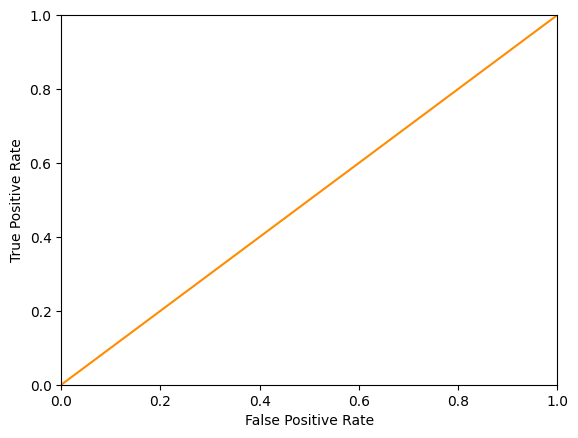

In [204]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Krzywa ROC AUC potwierdza losowość działania modelu.

<h1>Pierwszy model klasyfikacji - SVM</h1>

<h3>Standaryzacja</h3>

In [264]:
scaler = StandardScaler()
X_svm =X.copy()
cols = X_svm[['Age','SibSp','Parch','Fare','FamilyMembers']]
X_svm[['Age','SibSp','Parch','Fare','FamilyMembers']] = scaler.fit_transform(cols)
print(X_svm)

             Pclass       Age     SibSp     Parch      Fare  Embarked  Sex  \
PassengerId                                                                  
1                 3 -0.538891  0.432793 -0.473674 -0.502445         2    0   
2                 1  0.544133  0.432793 -0.473674  0.786845         1    1   
3                 3 -0.268135 -0.474545 -0.473674 -0.488854         2    1   
4                 1  0.341066  0.432793 -0.473674  0.420730         2    1   
5                 3  0.341066 -0.474545 -0.473674 -0.486337         2    0   
...             ...       ...       ...       ...       ...       ...  ...   
887               2 -0.200446 -0.474545 -0.473674 -0.386671         2    0   
888               1 -0.741958 -0.474545 -0.473674 -0.044381         2    1   
889               3  1.017956  0.432793  2.008933 -0.176263         2    1   
890               1 -0.268135 -0.474545 -0.473674 -0.044381         1    0   
891               3  0.137999 -0.474545 -0.473674 -0.492378     

Standaryzacja cech liczbowych żeby żadna nie była ważniejsza od innych - ważne dla modeli liniowych.

<h3>Hiperparametry: kernel='poly'</h3>

In [265]:
X_train, X_test, y_train, y_test = train_test_split(X_svm, y, train_size=0.8)
model = SVC(kernel='poly', probability=True) #probability=True umożliwia zrobienie krzywej ROC AUC
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test) 
y_pred_train = model.predict(X_train)

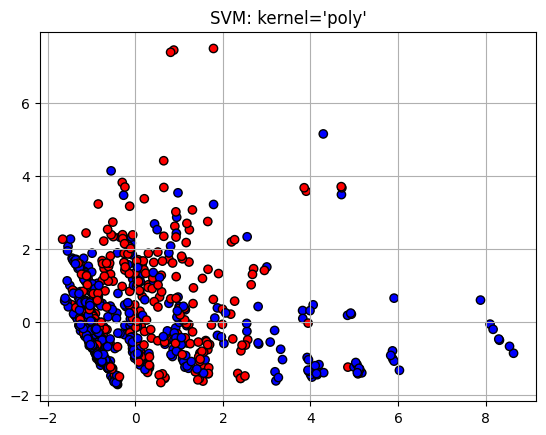

In [267]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_svm)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='bwr', edgecolor='k')
plt.title("SVM: kernel='poly'")
plt.grid(True)
plt.show()

(pca zostało zastosowane, aby umożliwić wizualizację w przestrzeni 2D)

<h3>Metryki dla zbioru testowego</h3>

In [268]:
print("Dokładność:", round(accuracy_score(y_test, y_pred_test), 2))
print("Precyzja: ", round(precision_score(y_test, y_pred_test), 2))
print("Czułość:", round(recall_score(y_test, y_pred_test), 2))

Dokładność: 0.83
Precyzja:  0.84
Czułość: 0.7


Model osiąga dość dobre wyniki dla każdej z powyższych metryk.

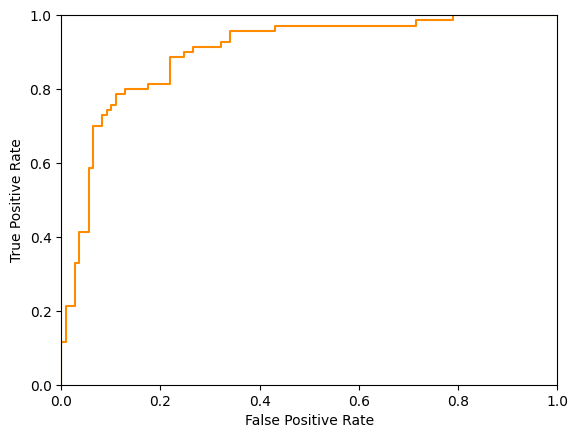

In [269]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

<h3>Metryki dla zbioru treningowego</h3>

In [270]:
print("Dokładność:", round(accuracy_score(y_train, y_pred_train), 2))
print("Precyzja: ", round(precision_score(y_train, y_pred_train), 2))
print("Czułość:", round(recall_score(y_train, y_pred_train), 2))

Dokładność: 0.82
Precyzja:  0.79
Czułość: 0.72


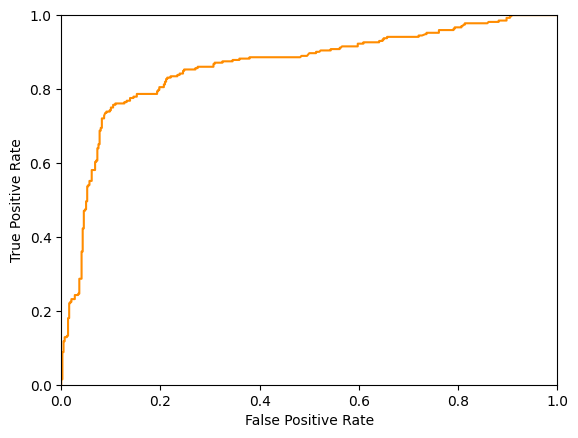

In [211]:
fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Wyniki dla badania na zbiorze treningowym prawie identyczne jak na testowym co świadczy o dobrym poziomie dopasowania modelu - nie jest ani niedouczony ani przeuczony.

<h3>Hiperparametry: kernel='rbf'</h3>

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X_svm, y, train_size=0.8)
model = SVC(probability=True)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test) 
y_pred_train = model.predict(X_train)

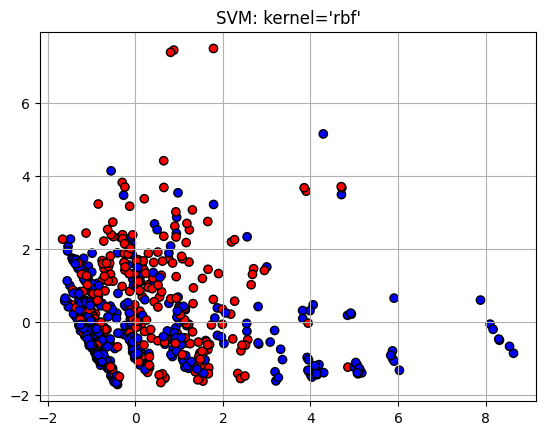

In [244]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_svm)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='bwr', edgecolor='k')
plt.title("SVM: kernel='rbf'")
plt.grid(True)
plt.show()

(testowałam też zrobienie pca przed treningiem modelu, ale otrzymywałam wtedy bardzo niskie wyniki czułości)

<h3>Metryki dla zbioru testowego</h3>

In [271]:
print("Dokładność:", round(accuracy_score(y_test, y_pred_test), 2))
print("Precyzja: ", round(precision_score(y_test, y_pred_test), 2))
print("Czułość:", round(recall_score(y_test, y_pred_test), 2))

Dokładność: 0.83
Precyzja:  0.84
Czułość: 0.7


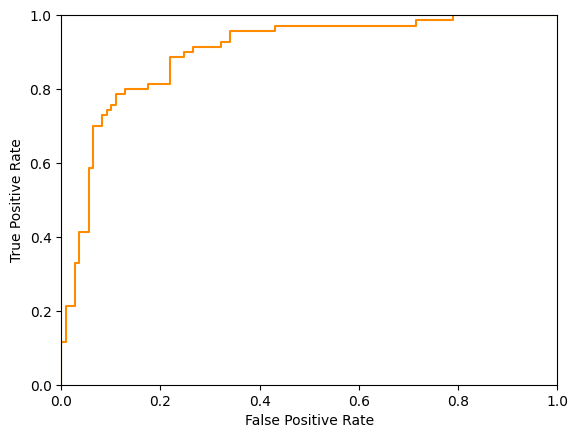

In [272]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

<h3>Metryki dla zbioru treningowego</h3>

In [273]:
print("Dokładność:", round(accuracy_score(y_train, y_pred_train), 2))
print("Precyzja: ", round(precision_score(y_train, y_pred_train), 2))
print("Czułość:", round(recall_score(y_train, y_pred_train), 2))

Dokładność: 0.82
Precyzja:  0.79
Czułość: 0.72


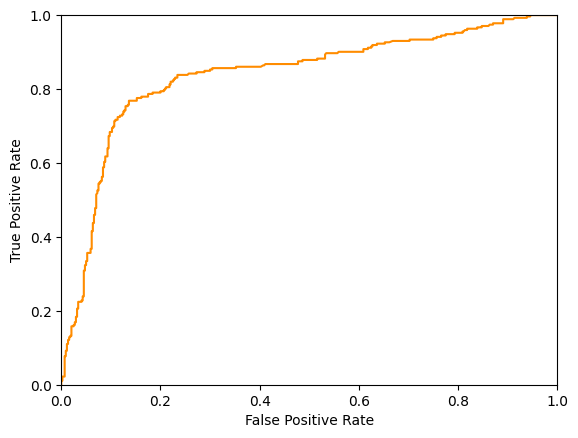

In [274]:
fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Tak jak przy poprzednich hiperparametrach wyniki dla badania na zbiorze treningowym prawie identyczne jak na testowym co świadczy o dobrym poziomie dopasowania modelu - nie jest ani niedouczony ani przeuczony. <br>
Dodatkowo wyniki dla obu kerneli są bardzo zbliżone.

<h1>Drugi model klasyfikacji - DecisionTree</h1>

Dla drzew nie ma potrzeby standaryzacji cech.

<h3>Hiperparametry: defaultowe</h3>

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test) 
y_pred_train = model.predict(X_train)

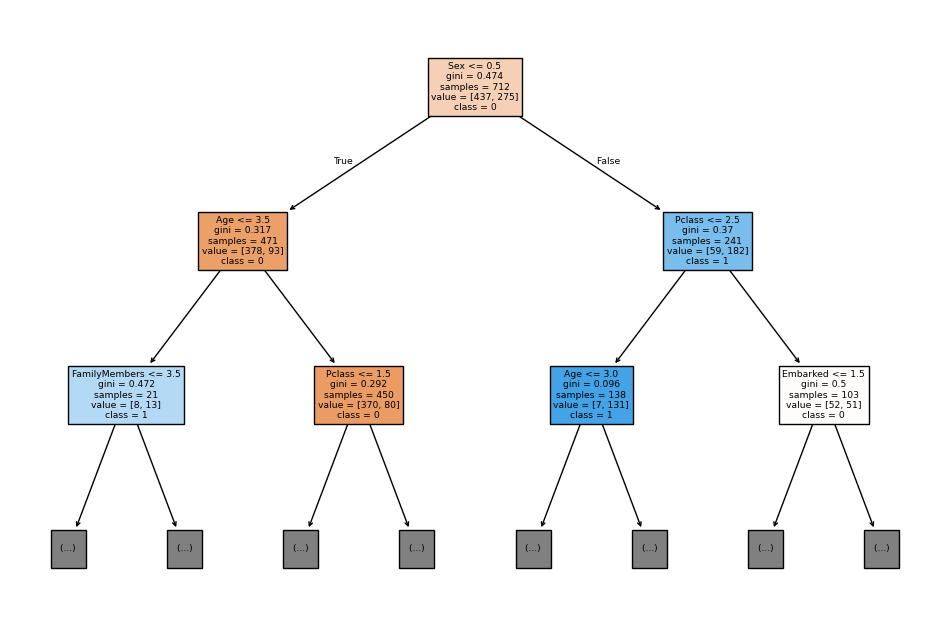

In [249]:
plt.figure(figsize=(12,8))
feature_names = X.columns.tolist()
class_names = y.astype(str).unique().tolist()
plot_tree(model, filled=True, feature_names=feature_names, class_names=class_names, max_depth=2)
plt.show()

(wizualizacja drzewa została okrojona bo całe było zbyt obszerne żeby dało się cokolwiek zobaczyć)

<h3>Metryki dla zbioru testowego</h3>

In [250]:
print("Dokładność:", round(accuracy_score(y_test, y_pred_test), 2))
print("Precyzja: ", round(precision_score(y_test, y_pred_test), 2))
print("Czułość:", round(recall_score(y_test, y_pred_test), 2))

Dokładność: 0.76
Precyzja:  0.67
Czułość: 0.72


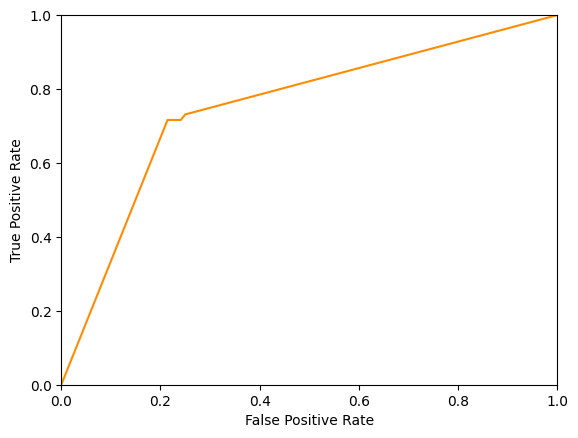

In [253]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

<h3>Metryki dla zbioru treningowego</h3>

In [251]:
print("Dokładność:", round(accuracy_score(y_train, y_pred_train), 2))
print("Precyzja: ", round(precision_score(y_train, y_pred_train), 2))
print("Czułość:", round(recall_score(y_train, y_pred_train), 2))

Dokładność: 0.99
Precyzja:  1.0
Czułość: 0.97


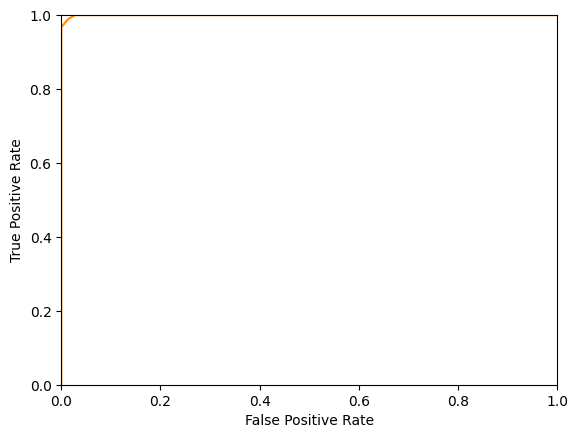

In [252]:
fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Widać, że metryki dla zbioru treningowego są praktycznie idealny - może to świadczyć o nadmiernym dopasowaniu modelu, ale też zachodzi z tego powodu, że drzewo decyzyjne budowało odpowiednie rozgałęzienia na podstawie dokładnie tych danych bez ograniczenia na głębokość takiego drzewa (ograniczenie te albo na minimalną liczbę próbek wymaganą do podziału mogłyby ograniczyć taki overfitting).

<h3>Hiperparametry: max_depth=6, min_samples_split=10</h3>

In [258]:
model = DecisionTreeClassifier(max_depth=6, min_samples_split=10)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test) 
y_pred_train = model.predict(X_train)

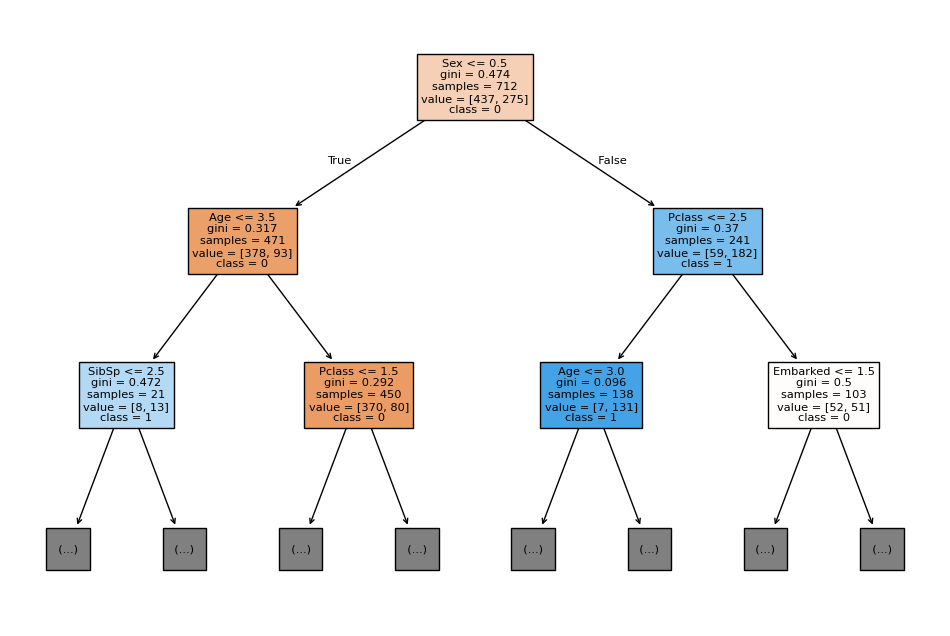

In [259]:
plt.figure(figsize=(12,8))
feature_names = X.columns.tolist()
class_names = y.astype(str).unique().tolist()
plot_tree(model, filled=True, feature_names=feature_names, class_names=class_names, max_depth=2)
plt.show()

<h3>Metryki dla zbioru testowego</h3>

In [260]:
print("Dokładność:", round(accuracy_score(y_test, y_pred_test), 2))
print("Precyzja: ", round(precision_score(y_test, y_pred_test), 2))
print("Czułość:", round(recall_score(y_test, y_pred_test), 2))

Dokładność: 0.8
Precyzja:  0.8
Czułość: 0.64


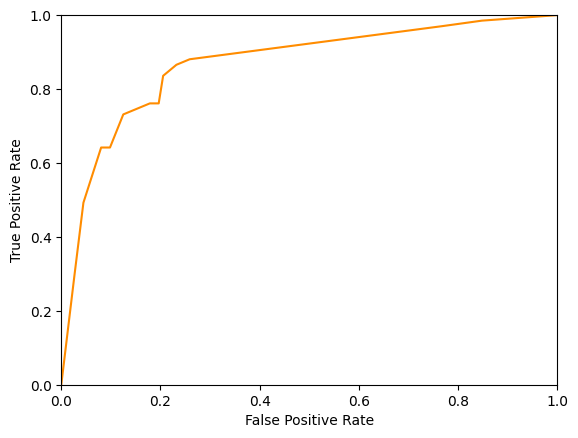

In [263]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

<h3>Metryki dla zbioru treningowego</h3>

In [261]:
print("Dokładność:", round(accuracy_score(y_train, y_pred_train), 2))
print("Precyzja: ", round(precision_score(y_train, y_pred_train), 2))
print("Czułość:", round(recall_score(y_train, y_pred_train), 2))

Dokładność: 0.86
Precyzja:  0.96
Czułość: 0.67


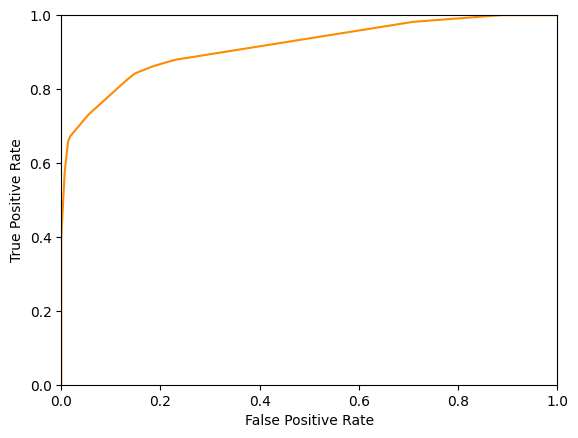

In [262]:
fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:,1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Po ograniczeniu dopasowania modelu za pomocą hiperparametrów możemy zauważyć, że wyniki dla zbioru traningowego i testowego są bardziej zbliżone do siebie niż w przypadku kiedy nie zostały zastosowane takie ograniczenia.

<h1>Podsumowanie</h1>

1. Oba modele wypadły lepiej od modelu klasyfikującego losowo
2. Oba modele mają podobne wyniki metryk dla naszego zbioru danych
3. Model SVM wypada podobnie dla obu hiperparametrów kernela (poly i rbf)
4. Drzewo decyzyjne przy ograniczonych parametrach uzyskuje lepsze wyniki dla zbioru testowego dzięki ograniczeniu dopasowania do danych treningowych

<h1>Wnioski</h1>

1. Hiperparametry mają wpływ na dopasowanie modelu do danych treningowych - w zależności od zbioru danych, modelu i hiperparametrów wpływ ten może być różny
2. Różne modele mogą różnie się sprawdzać dla różnych zbiorow danych.
3. Na dopasowanie modelu może mieć też wpływ sposób podziału danych na zbiór treningowy i testowy - im mniej danych użyjemy do